In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Load dataset
df = pd.read_parquet('../data/cleaned_data_snappy.parquet')

In [3]:
# Downsample: Take 1 million rows for faster training
df_sample = df.sample(n=1000000, random_state=42)

In [4]:
# Log-transform target variable if right-skewed
df_sample['totalFare'] = np.log1p(df_sample['totalFare'])

In [5]:
# Sort by `daysToDeparture` instead of `flightDate`
df_sample = df_sample.sort_values(by=['daysToDeparture'], ascending=False)

In [6]:
# Ensure `durationToDistanceRatio` exists
if 'durationToDistanceRatio' not in df_sample.columns:
    df_sample['durationToDistanceRatio'] = df_sample['totalAirtime'] / df_sample['totalTravelDistance']


In [7]:
# Replace infinite values and drop NaNs
df_sample['durationToDistanceRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_sample.dropna(subset=['durationToDistanceRatio'], inplace=True)

In [8]:
# Define features based on EDA insights
features = ['daysToDeparture', 'pricePerMile', 'isHoliday', 'preHolidayFlight', 
            'postHolidayFlight', 'totalLayoverTime', 'durationToDistanceRatio']

In [9]:
# Create lag features based on `daysToDeparture`
df_sample['fareLag_1'] = df_sample['totalFare'].shift(1)
df_sample['fareLag_7'] = df_sample['totalFare'].shift(7)
features += ['fareLag_1', 'fareLag_7']

In [10]:
# Drop NaNs created by lag features
df_sample.dropna(inplace=True)

In [11]:
# Define features (X) and target (y)
X = df_sample[features]
y = df_sample['totalFare']

In [12]:
# Normalize numerical data using Min-Max Scaling (needed for LSTM)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Convert to numpy arrays for LSTM processing
X_array = np.array(X_scaled)
y_array = np.array(y)

In [14]:
# Reshape for LSTM (samples, time steps, features)
X_lstm = np.reshape(X_array, (X_array.shape[0], 1, X_array.shape[1]))  # 1 time step


In [15]:
# Train-Test Split (80% Train, 10% Validation, 10% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X_lstm, y_array, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [16]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, stateful=False, input_shape=(1, X_lstm.shape[2])),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(50, return_sequences=False, stateful=False),
    Dropout(0.2),

    Dense(25, activation='relu'),
    Dense(1)  # Output Layer
])


C:\Users\Allison Conrey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [18]:
# Train Model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [19]:
# Reduce batch size for memory efficiency (32 instead of 64)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=20, batch_size=32, callbacks=[early_stop])


Epoch 1/20
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - loss: 0.8393 - mae: 0.4218 - val_loss: 0.0142 - val_mae: 0.0889
Epoch 2/20
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 0.0247 - mae: 0.1218 - val_loss: 0.0213 - val_mae: 0.1169
Epoch 3/20
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 0.0214 - mae: 0.1132 - val_loss: 0.0156 - val_mae: 0.0963
Epoch 4/20
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - loss: 0.0197 - mae: 0.1085 - val_loss: 0.0165 - val_mae: 0.1013


In [20]:
# Evaluate Model on Test Data
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert back from log scale
y_test_real = np.expm1(y_test)  # Convert back from log scale

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [21]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

In [22]:
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 38.7936
Test R² Score: 0.8669


In [24]:
print("Shape of y_test_real:", y_test_real.shape)
print("Shape of y_pred_real:", y_pred_real.shape)


Shape of y_test_real: (100000,)
Shape of y_pred_real: (100000, 1)


In [25]:
y_pred_real = y_pred_real.flatten()


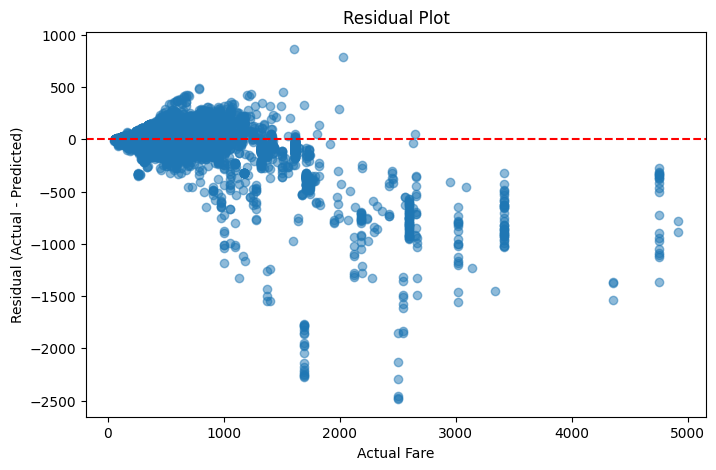

In [27]:
import matplotlib.pyplot as plt
# Residual Plot
residuals = y_test_real - y_pred_real
plt.figure(figsize=(8, 5))
plt.scatter(y_test_real, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Fare')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

In [28]:
# Feature Engineering
df['durationToDistanceRatio'] = df['totalAirtime'] / df['totalTravelDistance']
df['durationToDistanceRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['durationToDistanceRatio'], inplace=True)

In [29]:
# Add new features
df['isWeekend'] = (df['daysToDeparture'] % 7 >= 5).astype(int)  # 1 if Fri-Sun
df['fareLag_3'] = df['totalFare'].shift(3)  # Price 3 days ago
df['fareLag_7'] = df['totalFare'].shift(7)  # Price 7 days ago

In [30]:
# Define features based on EDA insights
features = ['daysToDeparture', 'pricePerMile', 'isHoliday', 'preHolidayFlight', 
            'postHolidayFlight', 'totalLayoverTime', 'durationToDistanceRatio', 
            'isWeekend', 'fareLag_3', 'fareLag_7']

In [31]:
df.dropna(inplace=True)  # Remove NaN values from lag features

In [32]:
# Define features (X) and target (y)
X = df[features]
y = df['totalFare']

In [33]:
# Normalize numerical data using Min-Max Scaling (needed for LSTM)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# Convert to numpy arrays for LSTM processing
X_array = np.array(X_scaled)
y_array = np.array(y)

In [35]:
# Reshape for LSTM (samples, time steps, features)
sequence_length = 5  # Experiment with 3-7 time steps
X_lstm = np.array([X_array[i-sequence_length:i] for i in range(sequence_length, len(X_array))])
y_lstm = y_array[sequence_length:]  # Align target variable

In [36]:
# Train-Test Split (80% Train, 10% Validation, 10% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [37]:
# Build Optimized LSTM Model
model = Sequential([
    LSTM(30, return_sequences=True, input_shape=(sequence_length, X_lstm.shape[2])),  # Reduce units
    Dropout(0.2),
    BatchNormalization(),

    LSTM(30, return_sequences=False),
    Dropout(0.2),

    Dense(15, activation='relu'),  # Reduce dense layer size
    Dense(1)  # Output Layer
])


C:\Users\Allison Conrey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Compile Model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [39]:
# Train Model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=20, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/20
96834/96834 ━━━━━━━━━━━━━━━━━━━━ 547s 6ms/step - loss: 23300.2598 - mae: 77.1191 - val_loss: 8815.1484 - val_mae: 48.1029
Epoch 2/20
96834/96834 ━━━━━━━━━━━━━━━━━━━━ 568s 6ms/step - loss: 12150.7754 - mae: 43.0997 - val_loss: 8196.1006 - val_mae: 47.1347
Epoch 3/20
96834/96834 ━━━━━━━━━━━━━━━━━━━━ 562s 6ms/step - loss: 11684.6826 - mae: 40.0728 - val_loss: 8972.9727 - val_mae: 55.9123
Epoch 4/20
96834/96834 ━━━━━━━━━━━━━━━━━━━━ 640s 7ms/step - loss: 11488.1445 - mae: 38.8267 - val_loss: 9316.7969 - val_mae: 59.4646
Epoch 5/20
96834/96834 ━━━━━━━━━━━━━━━━━━━━ 650s 6ms/step - loss: 11234.3262 - mae: 37.8150 - val_loss: 9952.4209 - val_mae: 64.0950


In [40]:
# Evaluate Model on Test Data
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert back from log scale
y_test_real = np.expm1(y_test)  # Convert back from log scale


12105/12105 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step


C:\Users\Allison Conrey\AppData\Local\Temp\ipykernel_12596\1943571796.py:3: RuntimeWarning: overflow encountered in expm1
  y_pred_real = np.expm1(y_pred)  # Convert back from log scale
C:\Users\Allison Conrey\AppData\Local\Temp\ipykernel_12596\1943571796.py:4: RuntimeWarning: overflow encountered in expm1
  y_test_real = np.expm1(y_test)  # Convert back from log scale
